In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from astropy.io import ascii
from scipy import interpolate
import emcee

In [3]:
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]
all_stars_in_selected_stars = all_stars_in_selected_stars[~np.isnan(all_stars_in_selected_stars["rrmscdpp06p0"])]

In [ ]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))
N = np.sum(observation)
observation = torch.Tensor(observation)

import glob

x = torch.zeros((0,7))
y = torch.zeros((0,11))

for i in glob.glob("simulations_etazero/data_x*"):
    run_label = i[34:]
    xnew = torch.load(i)
    ynew = torch.load("simulations_etazero/data_y_mult_hist_"+run_label)
    x = torch.concatenate((x,xnew),dim=0)
    y = torch.concatenate((y,ynew),dim=0)

#torch.save(x,"all_sims_x")
#torch.save(y,"all_sims_y")

print(x.shape)
valid_indices = torch.where(torch.sum(y,dim=1)>=108013)
invalid_indices = torch.where(torch.sum(y,dim=1)<108013)

x_invalid = x[invalid_indices]

x = x[valid_indices]
y = y[valid_indices]

print(x.shape)

norm_factor = (torch.max(x,dim=0)[0])



torch.Size([6942, 7])
torch.Size([2049, 7])


In [ ]:
class Emulator_0_or_1(nn.Module):
    def __init__(self):
        super(Emulator_0_or_1, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(6, 64)     
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 1)
                             
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.relu(self.fc1(x))      
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)      
        x = self.sigmoid(self.fc3(x))

        return x


model_0_or_1 = Emulator_0_or_1()
model_0_or_1.eval()
model_0_or_1.load_state_dict(torch.load("best_model_0_or_1", weights_only=True))


<All keys matched successfully>

In [ ]:

class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()
        

        self.fc1 = nn.Linear(6, 64)     
        self.fc2 = nn.Linear(64, 128)   
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)   
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 11)
                             
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        
        x = self.relu(self.fc1(x))      
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)      
        x = self.relu(self.fc3(x) )
        x = self.dropout(x)
        x = self.relu(self.fc4(x) )
        x = self.dropout(x)
        x = self.relu(self.fc5(x) )
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.log_softmax(self.fc7(x))        

        return x


model = Emulator()

model.eval()
model.load_state_dict(torch.load("best_model_0to10", weights_only=True))


<All keys matched successfully>

In [ ]:
@torch.no_grad()
def log_like(theta):
    theta_tensor = torch.as_tensor(theta[:-1], dtype=torch.float32)
    eta = torch.as_tensor(theta[-1], dtype=torch.float32)
    if eta >= 1.0:
        return -np.inf
    else:
        log_probs = model(theta_tensor / norm_factor[:-1]) + torch.log(1. - eta)
        if eta != 0.0:
            log_probs[0] = torch.logaddexp(torch.log(eta), log_probs[0])
        return torch.sum(observation * log_probs).item()
    #return 0.0

def log_prior(theta):
    rcrit, alpha_small, alpha_big, sigma, sigma_i, b, eta = theta
    logp = 0.0

    if 0.5 < rcrit < 30:
        logp += -np.log(rcrit)
    else:
        return -np.inf

    if not (-10 < alpha_small < 1):
        return -np.inf

    if not (1 < alpha_big < 10): 
        return -np.inf

    if 0 < sigma < 20:
        logp += -np.log(sigma)
    else:
        return -np.inf

    if not (0 < sigma_i < 20):
        return -np.inf

    if not (0 < b < 12):
        return -np.inf
        
    if not (0 < eta < 1):
        return -np.inf

    return logp


@torch.no_grad()
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    theta_tensor = torch.as_tensor(theta[:-1], dtype=torch.float32)
    if model_0_or_1(theta_tensor/norm_factor[:-1]) > 0.49:
        return lp #+ log_like(theta)
    elif model_0_or_1(theta_tensor/norm_factor[:-1]) <= 0.49:
        return -np.inf



In [ ]:
ndim = 7  # Number of parameters
nwalkers = 4 * ndim  # Recommended: 2-4 times ndim
nsteps = 50000
chunk_size = 1000  # Save every N steps
nchunks = nsteps // chunk_size
output_file = "mcmc_chain.h5"

backend = emcee.backends.HDFBackend(output_file)
backend.reset(nwalkers, ndim) 

p0 = np.random.uniform(
    low=[7, -0.8, 1.1, 5, 1, 5, 0.6],  # Lower bounds
    high=[8, -0.9, 1.11, 6, 2, 8, 0.7],  # Upper bounds
    size=(nwalkers, ndim)
)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,backend=backend)

#p0 = sampler.get_last_sample().coords

for i in range(nchunks):
    print(f"Running chunk {i+1}/{nchunks}...")
    sampler.run_mcmc(p0, chunk_size, progress=True)
    p0 = sampler.get_last_sample().coords
    print(f"Saved chunk {i+1} to {output_file}")


Running chunk 1/50...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 168.52it/s]


Saved chunk 1 to mcmc_chain.h5
Running chunk 2/50...


100%|██████████| 1000/1000 [00:06<00:00, 157.99it/s]


Saved chunk 2 to mcmc_chain.h5
Running chunk 3/50...


100%|██████████| 1000/1000 [00:11<00:00, 84.67it/s]


Saved chunk 3 to mcmc_chain.h5
Running chunk 4/50...


100%|██████████| 1000/1000 [00:12<00:00, 81.25it/s]


Saved chunk 4 to mcmc_chain.h5
Running chunk 5/50...


100%|██████████| 1000/1000 [00:12<00:00, 82.30it/s]


Saved chunk 5 to mcmc_chain.h5
Running chunk 6/50...


100%|██████████| 1000/1000 [00:12<00:00, 83.20it/s]


Saved chunk 6 to mcmc_chain.h5
Running chunk 7/50...


100%|██████████| 1000/1000 [00:11<00:00, 87.62it/s]


Saved chunk 7 to mcmc_chain.h5
Running chunk 8/50...


100%|██████████| 1000/1000 [00:11<00:00, 85.65it/s]


Saved chunk 8 to mcmc_chain.h5
Running chunk 9/50...


100%|██████████| 1000/1000 [00:12<00:00, 82.20it/s]


Saved chunk 9 to mcmc_chain.h5
Running chunk 10/50...


100%|██████████| 1000/1000 [00:11<00:00, 84.48it/s]


Saved chunk 10 to mcmc_chain.h5
Running chunk 11/50...


100%|██████████| 1000/1000 [00:06<00:00, 163.53it/s]


Saved chunk 11 to mcmc_chain.h5
Running chunk 12/50...


100%|██████████| 1000/1000 [00:05<00:00, 172.66it/s]


Saved chunk 12 to mcmc_chain.h5
Running chunk 13/50...


100%|██████████| 1000/1000 [00:05<00:00, 178.06it/s]


Saved chunk 13 to mcmc_chain.h5
Running chunk 14/50...


100%|██████████| 1000/1000 [00:05<00:00, 180.11it/s]


Saved chunk 14 to mcmc_chain.h5
Running chunk 15/50...


100%|██████████| 1000/1000 [00:05<00:00, 183.50it/s]


Saved chunk 15 to mcmc_chain.h5
Running chunk 16/50...


100%|██████████| 1000/1000 [00:05<00:00, 187.06it/s]


Saved chunk 16 to mcmc_chain.h5
Running chunk 17/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.91it/s]


Saved chunk 17 to mcmc_chain.h5
Running chunk 18/50...


100%|██████████| 1000/1000 [00:05<00:00, 176.25it/s]


Saved chunk 18 to mcmc_chain.h5
Running chunk 19/50...


100%|██████████| 1000/1000 [00:05<00:00, 172.83it/s]


Saved chunk 19 to mcmc_chain.h5
Running chunk 20/50...


100%|██████████| 1000/1000 [00:05<00:00, 176.73it/s]


Saved chunk 20 to mcmc_chain.h5
Running chunk 21/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.98it/s]


Saved chunk 21 to mcmc_chain.h5
Running chunk 22/50...


100%|██████████| 1000/1000 [00:05<00:00, 181.65it/s]


Saved chunk 22 to mcmc_chain.h5
Running chunk 23/50...


100%|██████████| 1000/1000 [00:05<00:00, 177.38it/s]


Saved chunk 23 to mcmc_chain.h5
Running chunk 24/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.68it/s]


Saved chunk 24 to mcmc_chain.h5
Running chunk 25/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.28it/s]


Saved chunk 25 to mcmc_chain.h5
Running chunk 26/50...


100%|██████████| 1000/1000 [00:05<00:00, 178.66it/s]


Saved chunk 26 to mcmc_chain.h5
Running chunk 27/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.90it/s]


Saved chunk 27 to mcmc_chain.h5
Running chunk 28/50...


100%|██████████| 1000/1000 [00:05<00:00, 176.71it/s]


Saved chunk 28 to mcmc_chain.h5
Running chunk 29/50...


100%|██████████| 1000/1000 [00:05<00:00, 180.28it/s]


Saved chunk 29 to mcmc_chain.h5
Running chunk 30/50...


100%|██████████| 1000/1000 [00:05<00:00, 174.92it/s]


Saved chunk 30 to mcmc_chain.h5
Running chunk 31/50...


100%|██████████| 1000/1000 [00:05<00:00, 177.42it/s]


Saved chunk 31 to mcmc_chain.h5
Running chunk 32/50...


100%|██████████| 1000/1000 [00:05<00:00, 180.03it/s]


Saved chunk 32 to mcmc_chain.h5
Running chunk 33/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.97it/s]


Saved chunk 33 to mcmc_chain.h5
Running chunk 34/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.92it/s]


Saved chunk 34 to mcmc_chain.h5
Running chunk 35/50...


100%|██████████| 1000/1000 [00:05<00:00, 181.67it/s]


Saved chunk 35 to mcmc_chain.h5
Running chunk 36/50...


100%|██████████| 1000/1000 [00:05<00:00, 178.22it/s]


Saved chunk 36 to mcmc_chain.h5
Running chunk 37/50...


100%|██████████| 1000/1000 [00:05<00:00, 178.92it/s]


Saved chunk 37 to mcmc_chain.h5
Running chunk 38/50...


100%|██████████| 1000/1000 [00:05<00:00, 174.33it/s]


Saved chunk 38 to mcmc_chain.h5
Running chunk 39/50...


100%|██████████| 1000/1000 [00:05<00:00, 177.31it/s]


Saved chunk 39 to mcmc_chain.h5
Running chunk 40/50...


100%|██████████| 1000/1000 [00:05<00:00, 180.72it/s]


Saved chunk 40 to mcmc_chain.h5
Running chunk 41/50...


100%|██████████| 1000/1000 [00:05<00:00, 174.60it/s]


Saved chunk 41 to mcmc_chain.h5
Running chunk 42/50...


100%|██████████| 1000/1000 [00:05<00:00, 182.22it/s]


Saved chunk 42 to mcmc_chain.h5
Running chunk 43/50...


100%|██████████| 1000/1000 [00:05<00:00, 175.79it/s]


Saved chunk 43 to mcmc_chain.h5
Running chunk 44/50...


100%|██████████| 1000/1000 [00:05<00:00, 176.13it/s]


Saved chunk 44 to mcmc_chain.h5
Running chunk 45/50...


100%|██████████| 1000/1000 [00:05<00:00, 177.14it/s]


Saved chunk 45 to mcmc_chain.h5
Running chunk 46/50...


100%|██████████| 1000/1000 [00:05<00:00, 179.23it/s]


Saved chunk 46 to mcmc_chain.h5
Running chunk 47/50...


100%|██████████| 1000/1000 [00:05<00:00, 181.15it/s]


Saved chunk 47 to mcmc_chain.h5
Running chunk 48/50...


100%|██████████| 1000/1000 [00:05<00:00, 177.12it/s]


Saved chunk 48 to mcmc_chain.h5
Running chunk 49/50...


100%|██████████| 1000/1000 [00:05<00:00, 180.69it/s]


Saved chunk 49 to mcmc_chain.h5
Running chunk 50/50...


100%|██████████| 1000/1000 [00:05<00:00, 173.36it/s]

Saved chunk 50 to mcmc_chain.h5


In [144]:
# Run after crash
backend = emcee.backends.HDFBackend(output_file)

last_sample = backend.get_last_sample()
p0 = last_sample.coords

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, backend=backend)

steps_remaining = nsteps - backend.iteration

for i in range(steps_remaining // chunk_size):
    print(f"Resuming: chunk {i+1}")
    sampler.run_mcmc(p0, chunk_size, progress=True)
    p0 = sampler.get_last_sample().coords


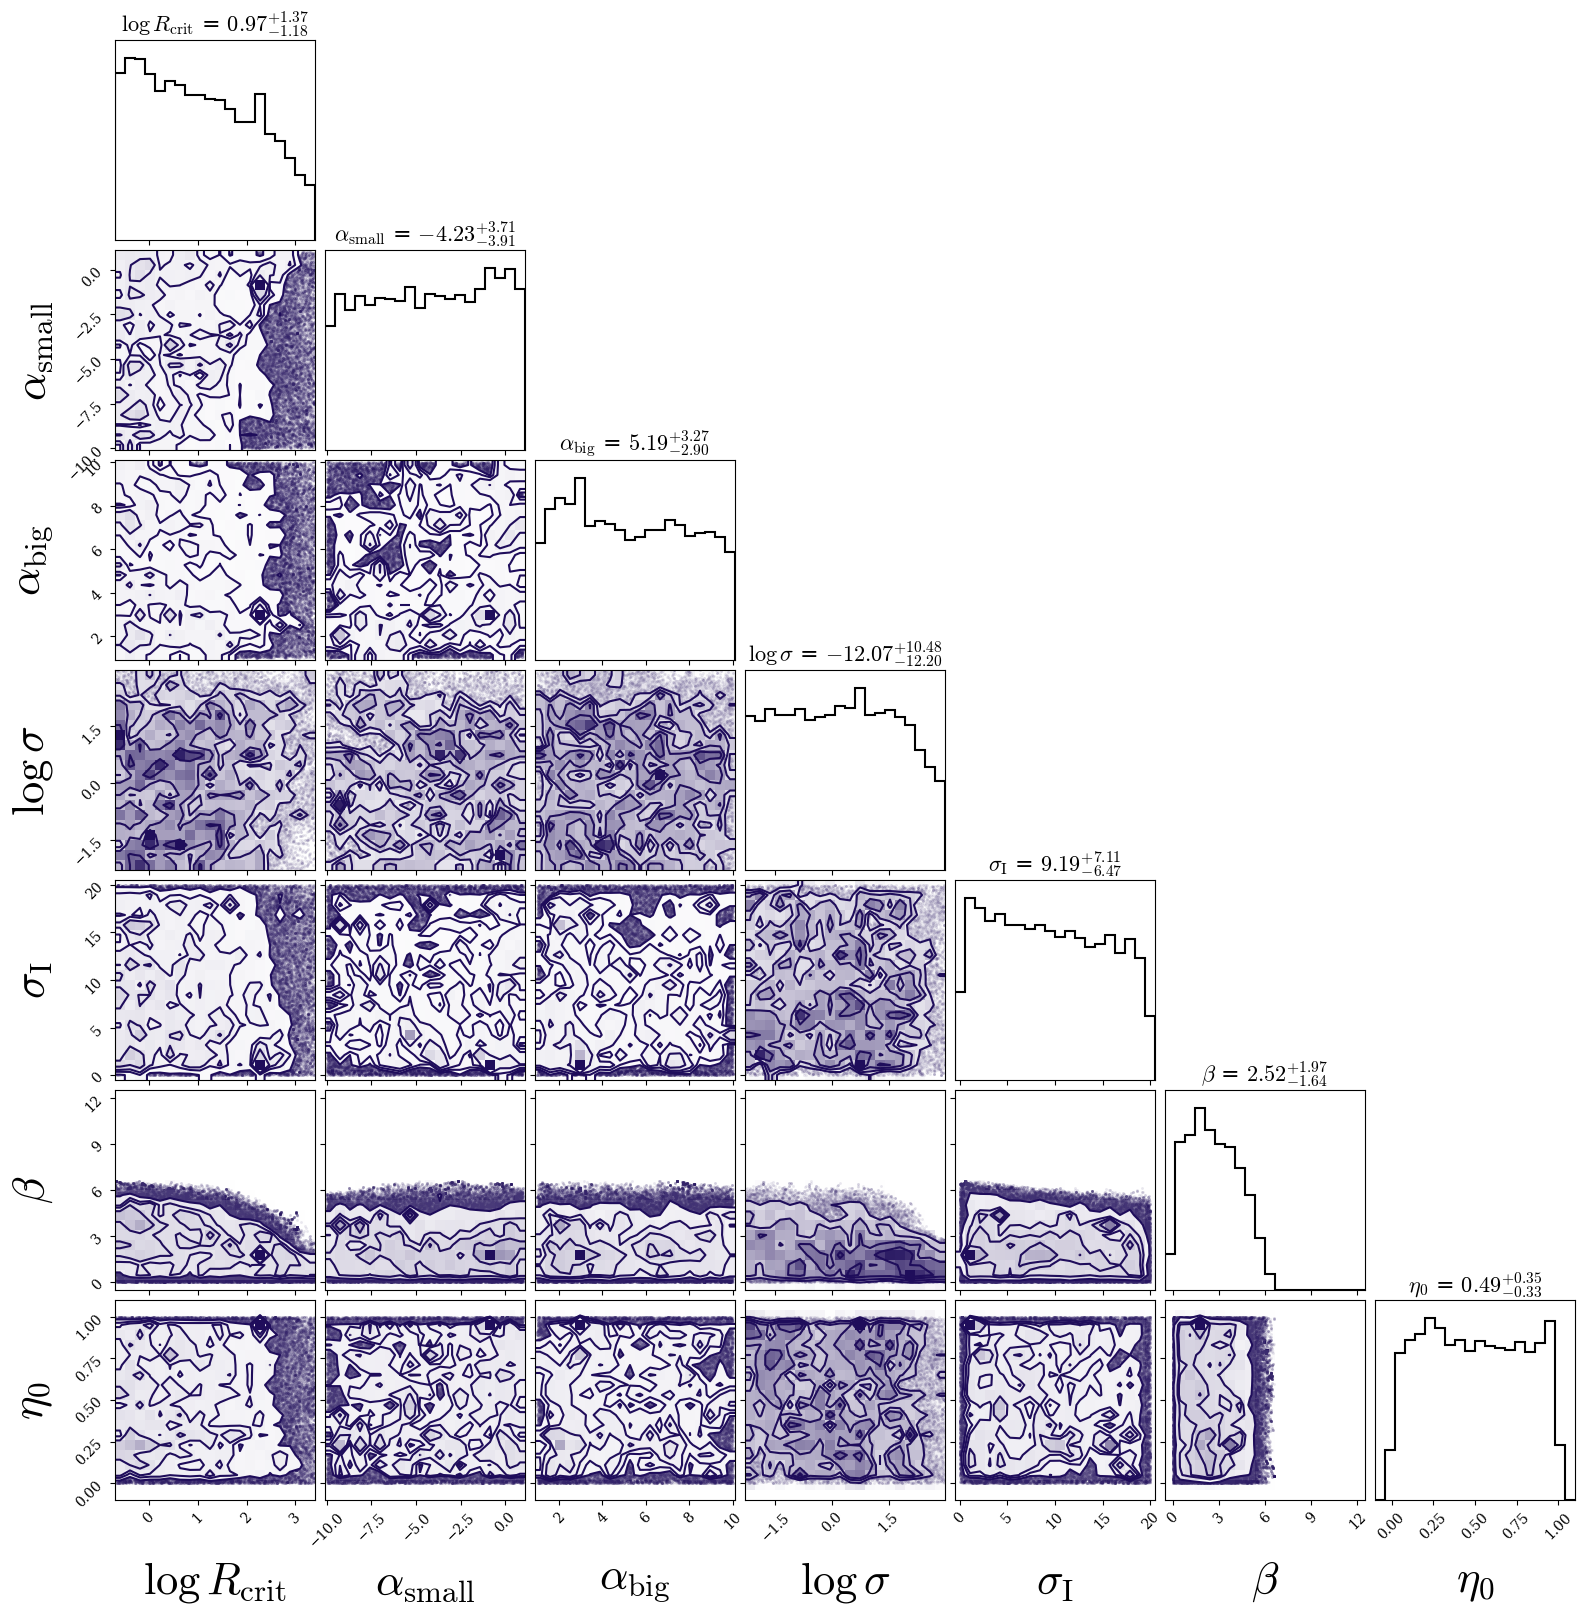

In [ ]:
import matplotlib.pyplot as plt
import corner
import numpy as np
from matplotlib import rcParams

rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm", 
    "text.latex.preamble": r'\usepackage{cmunitx}'
})

output_file = "mcmc_chain.h5"
backend = emcee.backends.HDFBackend(output_file)
samples = backend.get_chain(discard=1000, thin=10, flat=True)

samples_logplot = np.copy(samples)
samples_logplot[:, 0] = np.log(samples_logplot[:, 0])  # log(R_crit)
samples_logplot[:, 3] = np.log(samples_logplot[:, 3])  # log(sigma)

labels = [
    r"$\log R_{\text{crit}}$", 
    r"$\alpha_{\text{small}}$", 
    r"$\alpha_{\text{big}}$", 
    r"$\log \sigma$", 
    r"$\sigma_\text{I}$", 
    r"$\beta$", 
    r"$\eta_{0}$"
]

prior_ranges = [
    [np.log(0.5), np.log(30)],
    [-10.1, 1.1],                     
    [0.9, 10.1],                    
    [np.log(0.1), np.log(20)],  
    [-0.5, 20.5],                 
    [-0.5, 12.5],              
    [-0.1, 1.1],              
]


# Plot corner plot
fig = corner.corner(
    samples_logplot, 
    labels=labels, 
    color="#1f0d5b", 
    alpha=0.9, 
    show_titles=True, 
    range=prior_ranges,
    title_kwargs={"fontsize": 16}, 
    label_kwargs={"fontsize": 32}, 
    hist_kwargs={
        "color": "black",
        "fill": False,
        "linewidth": 1.5,
    },
    tick_kwargs={"labelsize": 14}
)

theta_median = np.median(samples, axis=0)
theta_std = np.std(samples, axis=0)


for ax in fig.get_axes():
    if not ax.has_data():
        continue  

    bbox = ax.get_position()
    fig.patches.append(plt.Rectangle(
        (bbox.x0, bbox.y0),
        bbox.width, bbox.height,
        transform=fig.transFigure,
        color="white", zorder=-1
    ))


fig.patch.set_alpha(0.0)


plt.savefig("corner_plot.png", bbox_inches="tight", transparent=True)



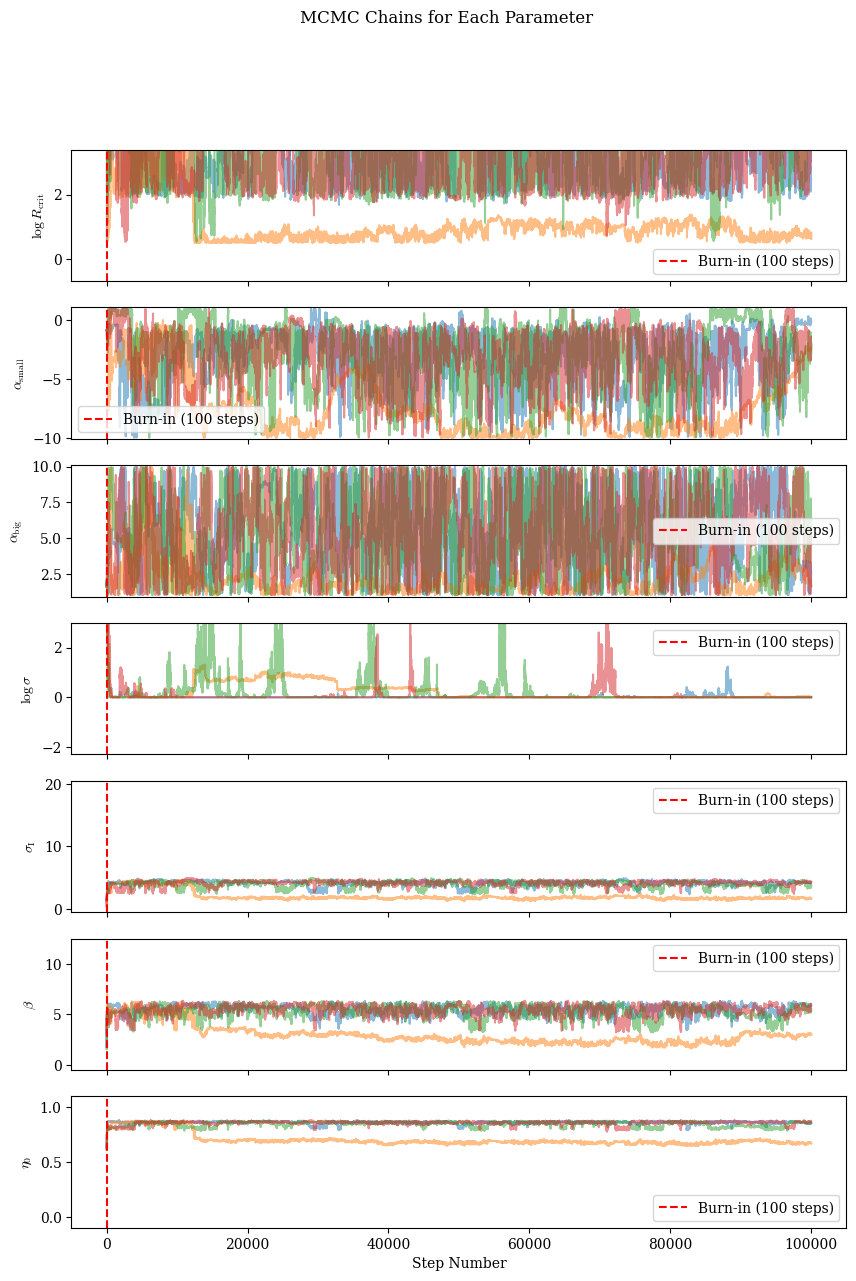

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Get the full chain (shape: nsteps, nwalkers, ndim)
chain = sampler.get_chain()

# Number of parameters
ndim = chain.shape[-1]

fig, axes = plt.subplots(ndim, figsize=(10, 2 * ndim), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[::2, ::8, i], alpha=0.5)  # Plot each walker
    ax.set_ylabel(f"{labels[i]}")
    ax.set_ylim(prior_ranges[i])  # Set y-limits from prior
    ax.axvline(x=100, color='r', linestyle='--', label="Burn-in (100 steps)")
    ax.legend()

axes[-1].set_xlabel("Step Number")
plt.suptitle("MCMC Chains for Each Parameter")
plt.show()


IndexError: index 6 is out of bounds for axis 0 with size 6

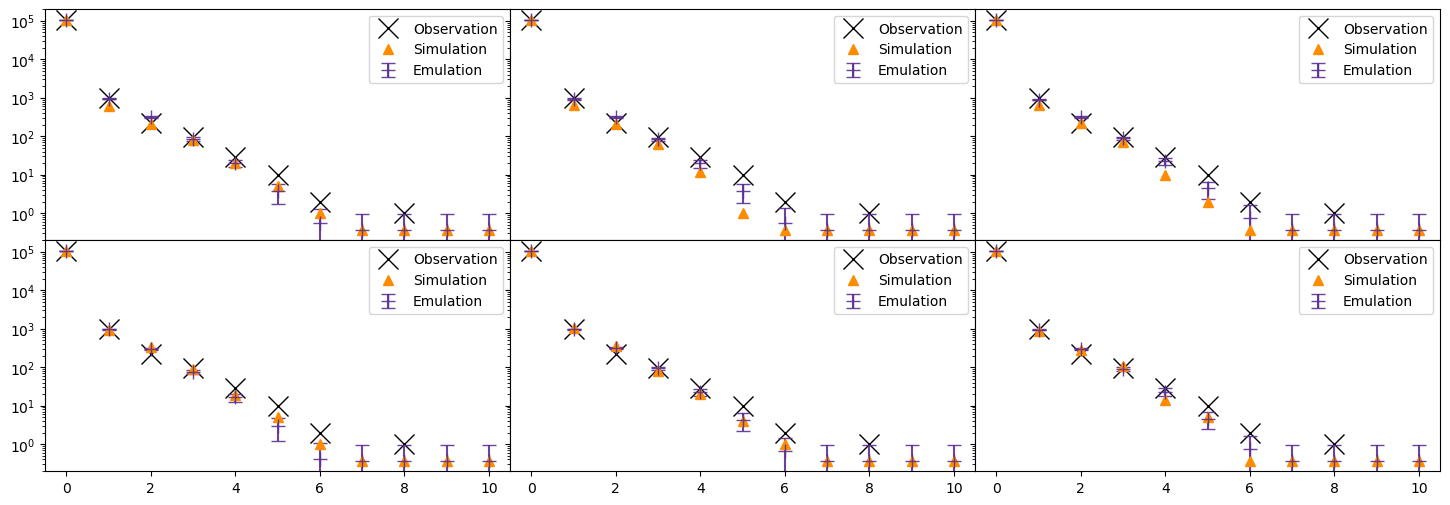

In [ ]:
sim_files_y = glob.glob("all_posterior_samples/data_y*")
sim_files_x = glob.glob("all_posterior_samples/data_x*")

sim_ys = []
sim_ys_v2 = []
sim_ys_v3 = []
sim_xs = []

ems_y = []
likes = []

for i, sim in enumerate(sim_files_y):
    if torch.sum(torch.load(sim)[0]) > 108013:
        if sim[-2:] == "v2":
            sim_ys_v2.append(torch.load(sim_files_y[i])[0])
        elif sim[-2:] == "v3":
            sim_ys_v3.append(torch.load(sim_files_y[i])[0])
        else:
            sim_ys.append(torch.load(sim_files_y[i])[0])
            theta = torch.load(sim_files_x[i])[0]
            sim_xs.append(theta)
            #likes.append(log_like(theta))
            eta = torch.Tensor([theta[-1]])
            em = model(theta[:-1] / norm_factor[:-1]) + torch.log(1. - eta)
            if eta != 0.0:
                em[0] = torch.logaddexp(torch.log(eta), em[0])
            ems_y.append(em.detach().numpy())


sim_ys = np.array(sim_ys)
sim_ys_v2 = np.array(sim_ys_v2)
sim_ys_v3 = np.array(sim_ys_v3)
sim_xs = np.array(sim_xs)

ems_y = np.array(ems_y)

ems_y = np.exp(ems_y)*N
ems_y[ems_y<1/(np.e)] = 1/(np.e)
em_err = ems_y**0.5

sim_ys[sim_ys==0.0] = 1/(np.e)
sim_ys_v2[sim_ys_v2==0.0] = 1/(np.e)
sim_ys_v2[sim_ys_v2==0.0] = 1/(np.e)

n_plots = len(sim_ys[::6])
ncols = 3
nrows = int(np.ceil(n_plots / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3 * nrows), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
# Flatten the 2D array of axes to make it easier to iterate
axs = axs.flatten()

for i, y in enumerate(sim_ys):
    ax = axs[i]
    ax.semilogy(range(0, 11), observation, "x", markersize=15, color="black", label="Observation")
    ax.errorbar(range(0, 11), ems_y[i], yerr=em_err[i], fmt="+", markersize=10, capsize=5, color="#5A2E91",alpha=0.9 ,label="Emulation")
    ax.semilogy(range(0, 11), sim_ys[i], "^", markersize=7, color="darkorange", label="Simulation")

    ax.legend()


for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])


for ax in axs[-ncols:]:
    ax.set_xlabel("Multiplicity")
#plt.title("Em vs Sim from Sampled Posterior")
plt.tight_layout()
plt.show()
